In [1]:
import os
if os.name == 'nt':
    !dir "../dataset"
    !dir "../model"
else:
    !dir "../dataset"
    !dir "../model"

 Volume in drive C has no label.
 Volume Serial Number is CACB-8726

 Directory of C:\Users\L\Desktop\work\dataset

02/07/2019  05:11 PM    <DIR>          .
02/07/2019  05:11 PM    <DIR>          ..
02/01/2019  12:34 AM         4,124,645 neg.txt
02/01/2019  08:52 AM         7,948,509 new_bilstm_neg_tok.pkl
02/01/2019  08:52 AM        19,913,070 new_bilstm_pos_tok.pkl
02/01/2019  01:45 AM         7,722,752 new_neg_tok.pkl
02/01/2019  01:45 AM        19,505,617 new_pos_tok.pkl
02/01/2019  12:34 AM        10,450,593 pos.txt
02/07/2019  05:11 PM        33,609,153 train_test_data.npy
02/01/2019  12:57 AM        15,330,064 vc_redist.x64.exe
11/08/2018  12:30 AM    <DIR>          wongnai
11/08/2018  12:30 AM           629,380 wongnai_1.csv
11/08/2018  12:30 AM         3,131,209 wongnai_2.csv
11/08/2018  12:30 AM        17,993,664 wongnai_3.csv
11/08/2018  12:30 AM        10,423,335 wongnai_5.csv
              12 File(s)    150,781,991 bytes
               3 Dir(s)  16,494,632,960 bytes free
 

In [2]:
%matplotlib inline

#matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import itertools


def plot_accnloss(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)    
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    tick_marks = [0, 1]
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()
    
get_val = lambda arr: list(map(lambda x: x[1], arr))
print('')

In [3]:
import numpy as np
import pandas as pd
import pathlib

from attention import AttentionWithContext

import time, sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, GRU, Embedding, LSTM, Input
from keras.layers import Activation, Dropout, Flatten, Bidirectional, TimeDistributed, Reshape
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers, utils, regularizers
from keras import backend as K
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

import dill as pickle

[x_train, x_test, y_train, y_test] = np.load('../dataset/train_test_data.npy')
x_train = x_train.astype('int32')
x_test = x_test.astype('int32')
print(x_train.shape, y_train.shape)
print(x_train.dtype, y_train.dtype)
print(x_test.shape, y_test.shape)
print(x_test.dtype, y_test.dtype)

print(f'pos size = { len(y_test[np.where( y_test[:,0] == 0 )]) }')
print(f'neg size = { len(y_test[np.where( y_test[:,0] == 1 )]) }')

word_vec = np.load('../model/vec.npy')

print(K.floatx()) # should equal float32

Using TensorFlow backend.


(9410, 600) (9410, 2)
int32 int32
(1661, 600) (1661, 2)
int32 int32
pos size = 1112
neg size = 549
float32


In [15]:
data_dim = 300
input_len = 600
num_classes = 2

dropout = 0.2
dense_dropout = 0.2
rnn_dropout = 0.1
learning_rate = 1e-3
batch_size = 50
epochs = 15

kernel_size = 3
pool_size = 2

# functional
'''
word_input = Input(shape=(input_len,), dtype='int32')
embed = Embedding(len(word_vec), data_dim, input_length=input_len, weights=[word_vec], trainable=True)(word_input)
birnn = Bidirectional(LSTM(150, return_sequences=True, dropout=dropout, recurrent_dropout=rnn_dropout))(embed)
dense = TimeDistributed(Dense(300))(birnn)
attnt = AttentionWithContext()(dense)
word_model = Model(word_input, attnt)
# word_model.summary()

model_input_w = Input(shape=(600, None), dtype='int32')
model_encoded = TimeDistributed(word_model)(model_input_w)
model_bidirnn = Bidirectional(LSTM(150, return_sequences=True, dropout=dropout, recurrent_dropout=rnn_dropout))(model_encoded)
model_t_dense = TimeDistributed(Dense(300))(model_bidirnn)
model_atttion = AttentionWithContext()(model_t_dense)
model_denseml = Dense(128, activation='tanh')(model_atttion)
model_dropout = Dropout(dense_dropout)(model_denseml)
model_predict = Dense(2, activation='softmax')(model_dropout)

model = Model(model_input_w, model_predict)
'''

# sequential
model = Sequential()
model.add(Embedding(len(word_vec), 300, input_length=input_len, weights=[word_vec], trainable=True))

# cnn
model.add(Conv1D(256, kernel_size, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(Conv1D(200, kernel_size, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size))

# 2blstm
model.add(Bidirectional(LSTM(150, return_sequences=True, dropout=dropout, recurrent_dropout=rnn_dropout)))
# model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=dropout, recurrent_dropout=rnn_dropout)))
# model.add(Bidirectional(LSTM(128, dropout=dropout, recurrent_dropout=rnn_dropout)))

# 2bgru
# model.add(Bidirectional(GRU(100, return_sequences=True, dropout=dropout, recurrent_dropout=rnn_dropout)))
model.add(Bidirectional(GRU(128, return_sequences=True, dropout=dropout, recurrent_dropout=rnn_dropout)))
# model.add(Bidirectional(GRU(128, dropout=dropout, recurrent_dropout=rnn_dropout)))

# attn (require return_sequences=True)
model.add(AttentionWithContext())
# model.add(Flatten())

model.add(Dense(128, activation='tanh'))
model.add(Dropout(dense_dropout))
model.add(Dense(2, activation='softmax'))

adam = optimizers.Adam(lr=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 600, 300)          19500000  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 600, 256)          230656    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 300, 256)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 300, 200)          153800    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 150, 200)          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 150, 300)          421200    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 150, 256)          329472    
__________

Train on 9410 samples, validate on 1661 samples
Epoch 1/15
9410/9410 [==============================] - 156s 17ms/step - loss: 0.6448 - acc: 0.6596 - val_loss: 0.6068 - val_acc: 0.7044

Epoch 00001: val_acc improved from -inf to 0.70439, saving model to ../model/result/20190208_040409/model_20190208_040409.hdf5
Epoch 2/15
9410/9410 [==============================] - 145s 15ms/step - loss: 0.5053 - acc: 0.7694 - val_loss: 0.2791 - val_acc: 0.8910

Epoch 00002: val_acc improved from 0.70439 to 0.89103, saving model to ../model/result/20190208_040409/model_20190208_040409.hdf5
Epoch 3/15
9410/9410 [==============================] - 145s 15ms/step - loss: 0.2234 - acc: 0.9140 - val_loss: 0.2651 - val_acc: 0.9019

Epoch 00003: val_acc improved from 0.89103 to 0.90187, saving model to ../model/result/20190208_040409/model_20190208_040409.hdf5
Epoch 4/15
9410/9410 [==============================] - 146s 16ms/step - loss: 0.1512 - acc: 0.9431 - val_loss: 0.2220 - val_acc: 0.9187

Epoch 00004: 

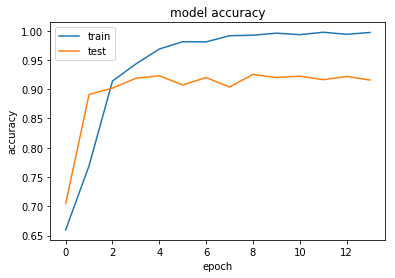

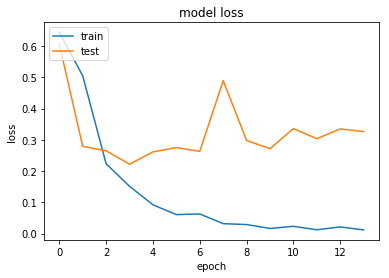

Normalized confusion matrix
[[0.9397482  0.0602518 ]
 [0.10382514 0.89617486]]


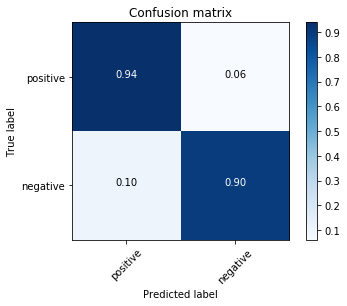

Confusion matrix, without normalization
[[1045   67]
 [  57  492]]


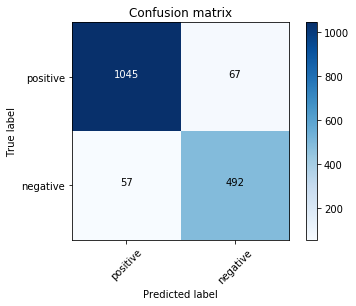

In [16]:
drive_path = '../model/result/'
date = time.strftime('%Y%m%d_%H%M%S')
pathlib.Path(f'{drive_path}{date}').mkdir(parents=True, exist_ok=True)
mon = 'val_acc'
mode_mon = 'max'
file_path = f'{drive_path}{date}/model_{date}.hdf5'
ckpt = ModelCheckpoint(file_path, monitor=mon, verbose=1, save_best_only=True, mode=mode_mon)
early = EarlyStopping(monitor=mon, mode=mode_mon, patience=5)

histories = []

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[ckpt, early])
del history.model
histories.append(history)

pickle.dump(histories, open(f'{drive_path}{date}/model_{date}_fitting_history.pkl', 'wb'))
        
model_name = f'{drive_path}{date}/model_{date}.h5'
model.save_weights(model_name)
model_json = model.to_json()

with open(f'{drive_path}{date}/model_{date}.json', "w") as json_file:
    json_file.write(model_json)
print("Saved model to disk")


model = load_model(file_path, custom_objects={'AttentionWithContext': AttentionWithContext})
print("Load best model from disk")

rand = np.random.choice(len(x_test), 10, replace=False)
for i in rand:
	pre_x, pre_y = x_test[i], y_test[i]
	pre_x = pre_x.reshape(1, input_len)
	res_y = model.predict_classes(pre_x, batch_size=1)
	print('Prediction: {}'.format(res_y[0]))
	print('Result: {}'.format(str(np.where(pre_y==1.)[0])[1]))

score = model.evaluate(x_test, y_test, batch_size=batch_size)
print("{}: {}".format(model.metrics_names[0], score[0]))
print("{}: {}%".format(model.metrics_names[1], score[1]*100))

y_true = get_val(y_test)
y_predict = model.predict_classes(x_test) 

print(metrics.classification_report(y_true, y_predict, target_names = ['negative', 'positive'], digits=6))

with open(f'{drive_path}{date}/model_{date}_result.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    f.write('{}: {}\n'.format(model.metrics_names[0], score[0]))
    f.write('{}: {}%\n'.format(model.metrics_names[1], score[1]*100))
    f.write('{}: {}%\n'.format('Report', metrics.classification_report(y_true, y_predict, target_names = ['negative', 'positive'], digits=6)))
    
    
plot_accnloss(history)

plot_confusion_matrix(confusion_matrix(y_true, y_predict, labels=[1,0]), 
                      classes=['positive', 'negative'], 
                      normalize=True,
                      title='Confusion matrix')

plot_confusion_matrix(confusion_matrix(y_true, y_predict, labels=[1,0]), 
                      classes=['positive', 'negative'], 
                      normalize=False,
                      title='Confusion matrix')
